In [1]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets

from dbc import *

In [2]:
X_train, y_train = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True, random_state=244)

In [3]:
DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=10,random_state=25)
DBC_kmeans.fit(X_train,y_train)
y_pred = DBC_kmeans.predict(X_train)
compute_conditional_risk(y_train, y_pred)

D:\program\Miniconda3\envs\RML\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\program\Miniconda3\envs\RML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\program\Miniconda3\envs\RML\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

(array([0.2208, 0.116 ]),
 array([[0.7792, 0.2208],
        [0.116 , 0.884 ]]))

In [4]:
DBC_kmeans.predict_prob(X_train)

array([[1.        , 0.        ],
       [0.8556701 , 0.1443299 ],
       [0.8556701 , 0.1443299 ],
       ...,
       [0.40206186, 0.59793814],
       [0.33333333, 0.66666667],
       [1.        , 0.        ]])

In [5]:
DBC_fcm = CmeansDiscreteBayesianClassifier(n_clusters=10, fuzzifier=1.5, cluster_centers=DBC_kmeans.cluster_centers)
DBC_fcm.fit(X_train,y_train)
y_pred = DBC_fcm.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.168, 0.176]),
 array([[0.832, 0.168],
        [0.176, 0.824]]))

In [6]:
DBC_fcm.predict_prob(X_train)

array([[0.98769343, 0.01230657],
       [0.756457  , 0.243543  ],
       [0.81493683, 0.18506317],
       ...,
       [0.42143582, 0.57856418],
       [0.44020524, 0.55979476],
       [0.92111777, 0.07888223]])

Text(0.5, 1.0, 'PDBC with soft clustering')

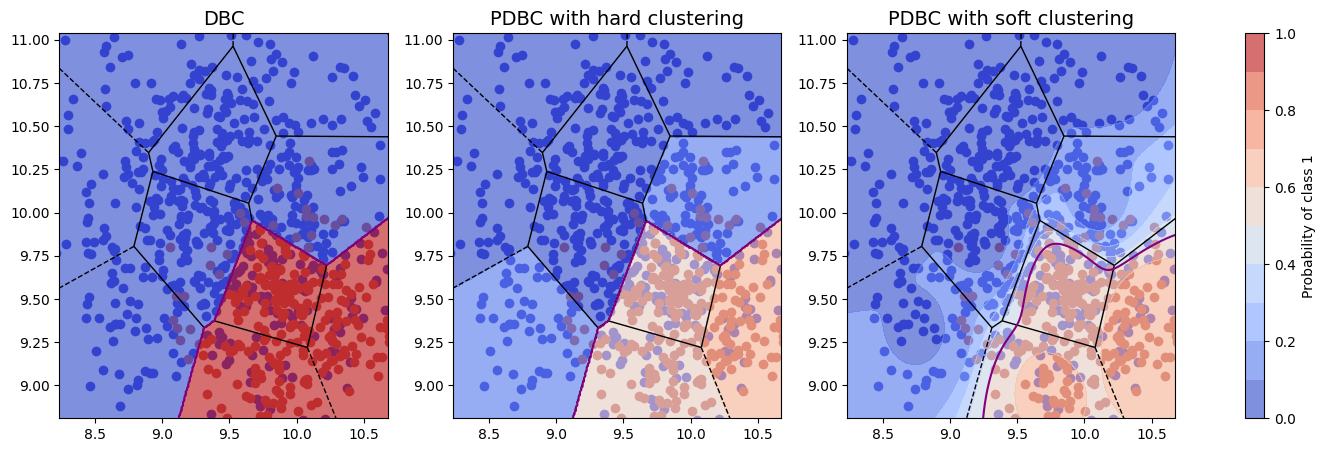

In [7]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DBC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DBC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2[:, 1].reshape(xx.shape)


class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5


boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DBC', fontsize=14)
ax[1].set_title('PDBC with hard clustering', fontsize=14)
ax[2].set_title('PDBC with soft clustering', fontsize=14)

In [8]:
DMC_kmeans = KmeansDiscreteMinimaxClassifier(n_clusters=10 ,random_state=25)
DMC_kmeans.fit(X_train,y_train)
y_pred = DMC_kmeans.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.2208, 0.116 ]),
 array([[0.7792, 0.2208],
        [0.116 , 0.884 ]]))

Text(0.5, 1.0, 'PDBC with soft clustering')

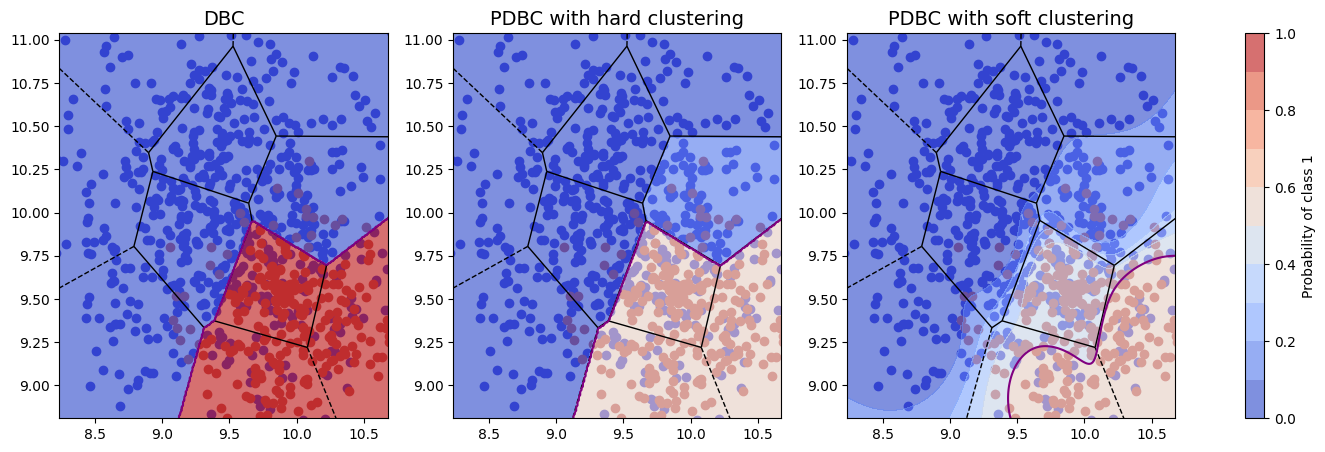

In [9]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DMC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DMC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=DMC_kmeans.prior_star)
Z2 = Z2[:, 1].reshape(xx.shape)


class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5


boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DBC', fontsize=14)
ax[1].set_title('PDBC with hard clustering', fontsize=14)
ax[2].set_title('PDBC with soft clustering', fontsize=14)

In [10]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=10)
DBC_DT.fit(X_train,y_train)
y_pred = DBC_DT.predict(X_train, prior_pred=DBC_DT.prior)
compute_conditional_risk(y_train, y_pred)

(array([0.032, 0.132]),
 array([[0.968, 0.032],
        [0.132, 0.868]]))

In [11]:
DBC_DT.predict_prob(X_train)

array([[1.        , 0.        ],
       [0.74545455, 0.25454545],
       [1.        , 0.        ],
       ...,
       [0.        , 1.        ],
       [0.38461538, 0.61538462],
       [1.        , 0.        ]])

In [12]:
DMC_DT = DecisionTreeDiscreteMinimaxClassifier(max_depth=10)
DMC_DT.fit(X_train,y_train)
y_pred = DMC_DT.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.0704, 0.056 ]),
 array([[0.9296, 0.0704],
        [0.056 , 0.944 ]]))